In [1]:
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

In [3]:
import pyqae.nd as ndt
from pyqae.nd import meshgridnd_like
import numpy as np

In [4]:
test_image = np.random.uniform(size = (32, 32, 32, 128))

xx, yy, zz, ch = meshgridnd_like(test_image)
test_image += np.sqrt(np.power(xx-10,2) + np.power(yy-20,2) + np.power(zz - 16,2))
test_image *= 1-ch/128.0

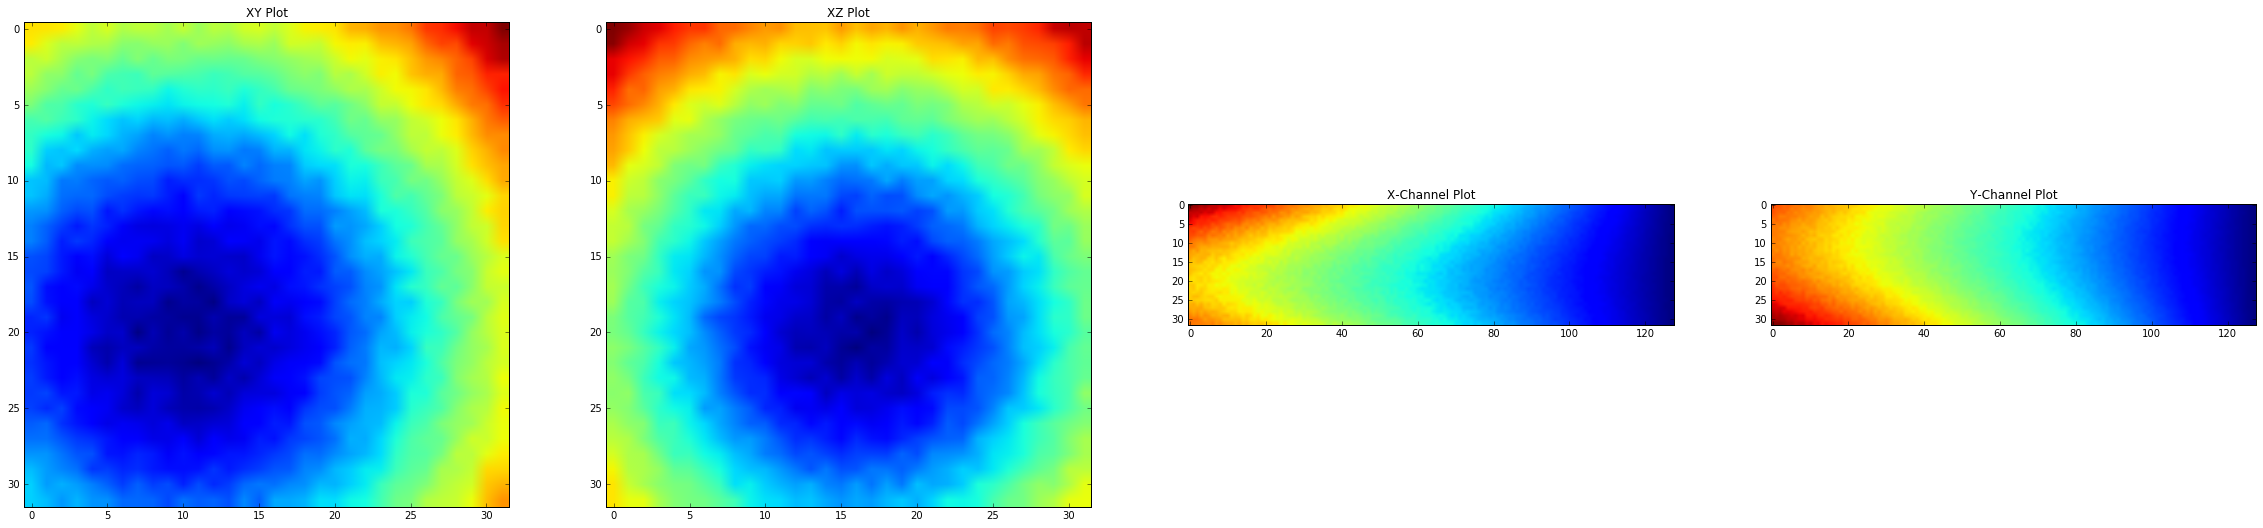

In [5]:
%matplotlib inline 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (40,10))
ax1.imshow(test_image[:,:,0,0].squeeze())
ax1.set_title('XY Plot')
ax2.imshow(test_image[:,0,:,0].squeeze())
ax2.set_title('XZ Plot')
ax3.imshow(test_image[:,0,0,:].squeeze())
ax3.set_title('X-Channel Plot')
ax4.imshow(test_image[0,:,0,:].squeeze())
ax4.set_title('Y-Channel Plot')

In [6]:
b_arr = ndt.array(test_image).chunk((8, 8, 8, 128))

AttributeError: 'BoltArrayLocal' object has no attribute 'chunk'

In [ ]:
b_arr.chunk((10,5))

In [ ]:
b_arr.map(lambda x: x*2).unchunk()

In [ ]:
?ndt.spark.chunk

In [140]:
from collections import defaultdict
class LocalRDD(object):
    """
    A simple, inefficient, approximation for a locally stored RDD object (a lazy list)
    """
    def __init__(self, kv_list, fcn_to_apply = None):
        """
        Parameters
        ----------
        kv_list : list
            the list of key value pairs
        fcn_to_apply : function
            the function that should be applied, ndarray -> ndarray
        """
        self.kv_list = kv_list
        self.lazy_fcn_list = [] if fcn_to_apply is None else fcn_to_apply
        self.cached_list = None
        
    def map(self, c_func):
        return LocalRDD(self.kv_list, fcn_to_apply = self.lazy_fcn_list + [c_func])
    
    def mapValues(self, c_func):
        return self.map(lambda (a,b): (a,c_func(b)))
    
    def flatMap(self, c_func):
        return self.map(c_func).map('flatten')
    
    def mapPartitions(self, c_func):
        """
        Make artificial partitions and executes the function on each one
        """
        return self.map(lambda (k,v): c_func([(k,v)]))
    
    def partitionBy(self, numPartitions, partitionFunc):
        """
        The current operations need to be executed before they can be handed off to the partition function
        """
        return LocalPartitionedRDD(self.collect(), partitionFunc)
    
    def values(self):
        return self.map(lambda (_, v): v)
    
    def filter(self, f_func):
        #TODO make this lazy as well
        return LocalRDD(filter(f_func, self.collect()))
    
    def first(self):
        return self.collect()[0]
    
    def collect(self):
        if self.cached_list is None:
            self.cached_list = LocalRDD.expand(self)
        return self.cached_list
    
    @property
    def context(self):
        # making a new one is easier
        return LocalSparkContext()
    
    @staticmethod
    def expand(curRDD):
        last_list = curRDD.kv_list
        for c_func in curRDD.lazy_fcn_list:
            if c_func == 'flatten':
                out_list = []
                for i in last_list: 
                    out_list += i
                last_list = out_list
            else:
                last_list = map(c_func, last_list)
        return last_list         

class LocalPartitionedRDD(object):
    
    def __init__(self, kv_list, partitionFunc, part_rdd = None):
        """
        Creates a partitioned RDD which supports mapPartitions and values operations
        
        Parameters
        ----------
        kv_list : list[(k,v)]
            the list of key values
        partitionFunc : function
            apply to the keys to put them in distinct partitions
        part_rdd : dict
            to supply the already partitioned dataset with keys as the partition ids
            and values as the partition contents
        """
        if part_rdd is None:
            self.part_rdd = defaultdict(list)
            for (k,v) in kv_list:
                self.part_rdd[partitionFunc(k)]+=[(k,v)]
        else:
            self.part_rdd = part_rdd
        self.partitionFunc = partitionFunc
        self.kv_list = kv_list
    
    def mapPartitions(self, c_func):
        new_part_values = {}
        new_kv_list = []
        for partName, partValues in self.part_rdd.iteritems():
            new_values = c_func(partValues)
            new_part_values[partName] = new_values
            new_kv_list += new_values
        return LocalPartitionedRDD(new_kv_list, self.partitionFunc, part_rdd = new_part_values)
    
    def values(self):
        return LocalRDD(self.kv_list, [lambda (_, v): v])

class LocalSparkContext(object):
    def __init__(self):
        pass
    def parallelize(self, in_list, npartitions = 0):
        return LocalRDD(in_list)
    

In [124]:
from pyqae.nd import sp_array
py_arr = sp_array(xx.astype(np.uint8), LocalSparkContext(),3)
#py_arr.chunk((8, 8, 8, 128))

In [125]:
chk_image = py_arr.chunk((8, 8, 8))
p_chk_image = chk_image.map(lambda x: x+1)
n_image = p_chk_image.unchunk()

In [122]:
chk_image.tordd().first()[1].shape

(8, 8, 8)

In [126]:
from skimage.filters.rank import median
from skimage.morphology import disk
filtered = chk_image.map(lambda x: median(x[:,:,0], disk(3))).unchunk().squeeze().toarray()

NotImplementedError: map on ChunkedArray cannot drop dimensions

In [142]:
n_image.toarray()[0,0]

array([[ 1,  1,  1, ...,  4,  4,  4],
       [ 5,  5,  5, ...,  8,  8,  8],
       [ 9,  9,  9, ..., 12, 12, 12],
       ..., 
       [21, 21, 21, ..., 24, 24, 24],
       [25, 25, 25, ..., 28, 28, 28],
       [29, 29, 29, ..., 32, 32, 32]], dtype=uint8)

In [78]:
p_chk_image.tordd().lazy_fcn_list[-1]((5,0))

AttributeError: 'int' object has no attribute 'shape'

In [86]:
py_arr.map(lambda x: x+1).toarray()

array([[[[ 1,  1,  1, ...,  4,  4,  4],
         [ 5,  5,  5, ...,  8,  8,  8],
         [ 9,  9,  9, ..., 12, 12, 12],
         ..., 
         [21, 21, 21, ..., 24, 24, 24],
         [25, 25, 25, ..., 28, 28, 28],
         [29, 29, 29, ..., 32, 32, 32]],

        [[ 1,  1,  1, ...,  4,  4,  4],
         [ 5,  5,  5, ...,  8,  8,  8],
         [ 9,  9,  9, ..., 12, 12, 12],
         ..., 
         [21, 21, 21, ..., 24, 24, 24],
         [25, 25, 25, ..., 28, 28, 28],
         [29, 29, 29, ..., 32, 32, 32]],

        [[ 1,  1,  1, ...,  4,  4,  4],
         [ 5,  5,  5, ...,  8,  8,  8],
         [ 9,  9,  9, ..., 12, 12, 12],
         ..., 
         [21, 21, 21, ..., 24, 24, 24],
         [25, 25, 25, ..., 28, 28, 28],
         [29, 29, 29, ..., 32, 32, 32]],

        ..., 
        [[ 1,  1,  1, ...,  4,  4,  4],
         [ 5,  5,  5, ...,  8,  8,  8],
         [ 9,  9,  9, ..., 12, 12, 12],
         ..., 
         [21, 21, 21, ..., 24, 24, 24],
         [25, 25, 25, ..., 28, 28, 28],


In [97]:
LocalRDD.expand(p_chk_image.tordd())[0]

((0, 0, 0, 0), array([[[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0

In [109]:
t_rdd = py_arr.chunk((8, 8, 8)).tordd()
for a, b in t_rdd.lazy_fcn_list[0](t_rdd.kv_list[0]):
    print(a, b.shape)

((0, 0, 0, 0), (8, 8, 8))
((0, 0, 0, 1), (8, 8, 8))
((0, 0, 0, 2), (8, 8, 8))
((0, 0, 0, 3), (8, 8, 8))
((0, 0, 0, 4), (8, 8, 8))
((0, 0, 0, 5), (8, 8, 8))
((0, 0, 0, 6), (8, 8, 8))
((0, 0, 0, 7), (8, 8, 8))
((0, 0, 0, 8), (8, 8, 8))
((0, 0, 0, 9), (8, 8, 8))
((0, 0, 0, 10), (8, 8, 8))
((0, 0, 0, 11), (8, 8, 8))
((0, 0, 0, 12), (8, 8, 8))
((0, 0, 0, 13), (8, 8, 8))
((0, 0, 0, 14), (8, 8, 8))
((0, 0, 0, 15), (8, 8, 8))
((0, 0, 1, 0), (8, 8, 8))
((0, 0, 1, 1), (8, 8, 8))
((0, 0, 1, 2), (8, 8, 8))
((0, 0, 1, 3), (8, 8, 8))
((0, 0, 1, 4), (8, 8, 8))
((0, 0, 1, 5), (8, 8, 8))
((0, 0, 1, 6), (8, 8, 8))
((0, 0, 1, 7), (8, 8, 8))
((0, 0, 1, 8), (8, 8, 8))
((0, 0, 1, 9), (8, 8, 8))
((0, 0, 1, 10), (8, 8, 8))
((0, 0, 1, 11), (8, 8, 8))
((0, 0, 1, 12), (8, 8, 8))
((0, 0, 1, 13), (8, 8, 8))
((0, 0, 1, 14), (8, 8, 8))
((0, 0, 1, 15), (8, 8, 8))
((0, 0, 2, 0), (8, 8, 8))
((0, 0, 2, 1), (8, 8, 8))
((0, 0, 2, 2), (8, 8, 8))
((0, 0, 2, 3), (8, 8, 8))
((0, 0, 2, 4), (8, 8, 8))
((0, 0, 2, 5), (8, 8, 8))


In [110]:
from bolt.spark.construct import ConstructSpark as cs

In [111]:
cs._wrap

<function bolt.spark.construct._wrap>

In [114]:
from bolt.construct import ConstructBase
from bolt.spark.construct import ConstructSpark as cs
import numpy as np
#from bolt.localspark import LocalSparkContext


class ConstructLocalSpark(ConstructBase):

    @staticmethod
    def array(a, context=None, axis=(0,), dtype=None, npartitions=None):
		return cs.array(a, context = LocalSparkContext(), axis = axis, 
                        dtype=dtype, npartitions=npartitions)

    @staticmethod
    def ones(shape, context=None, axis=(0,), dtype=np.float64, npartitions=None):
        return cs.ones(a, context = LocalSparkContext(), axis = axis, 
                       dtype=dtype, npartitions=npartitions)

    @staticmethod
    def zeros(shape, context=None, axis=(0,), dtype=np.float64, npartitions=None):
        return cs.zeros(a, context = LocalSparkContext(), axis = axis, 
                        dtype=dtype, npartitions=npartitions)

    @staticmethod
    def concatenate(arrays, axis=0):
        return cs.concatenate(array, axis = axis)

    @staticmethod
    def _argcheck(*args, **kwargs):
        """
        Check that arguments are consistent with localspark array construction.

        Condition is
        (1) keyword arg 'context' is the string 'fake'
        """
        
        return kwargs.get('context', '').find('fake')>=0

    @staticmethod
    def _format_axes(axes, shape):
        return cs._format_axes(axes, shape)

    @staticmethod
    def _wrap(func, shape, context=None, axis=(0,), dtype=None, npartitions=None):
        return cs._wrap(func, shape = shape, context = LocalSparkContext(), axis = axis, 
                        dtype = dtype, npartitions = npartitions)


In [127]:
from sklearn import datasets
from numpy import asarray
imgs = datasets.load_sample_images()
im = asarray([imgs.images[0], imgs.images[1]])

ImportError: The Python Imaging Library (PIL) is required to load data from jpeg files

In [137]:
im = np.random.uniform(0,255, size = (2,800, 800, 3)).astype(np.uint8)

In [143]:
b = sp_array(im, LocalSparkContext(), (0,))

In [144]:
rgb = b[:,0:400,0:600,:]

In [147]:
rgb.values.shape

(400, 600, 3)

In [148]:
chunks = rgb.chunk(size=(100,100,3))

In [149]:
chunks.tordd().values().first().shape

(100, 100, 3)

In [150]:
gray = chunks.map(lambda x: x[:,:,0]).unchunk().squeeze().toarray()

NotImplementedError: map on ChunkedArray cannot drop dimensions